*To do*
1. Is there a way to avoid having to manually call the functions 10 times? Maybe with range()?

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Making PKW dataframes from the years where we have a CSV

This is for all years 2013 to 2017 inclusive.

In [3]:
#List of columns that we want as they are listed in CSV files. New list uses Python numbering.
csv_col_list = [1,7,19,21,36,37,40,41,44,45,46,47,48,49,50,51,52]
py_col_list = [i - 1 for i in csv_col_list]

#function to import a CSV file for a year into a dataframe
def CSVtoPD(year):
    filepath = "data/" + str(year) + " formatted.csv"
    
    #removes columns and rows that we don't want
    df = pd.read_csv(filepath,usecols=py_col_list)
    df = df.drop([0],axis=0)
    
    #this column is useful in 2017 because it has Elektro but is irrelevant otherwise
    if year != 2017:
        #for years other than 2017, changes values to 0
        df.iloc[:,8] = 0
        #for years other than 2017, renames column 
        df.columns.values[8] = "PKW Elektro"

    
    #function to tidy up the city names
    def change_name(name):
        split_name = name.split()
        return(split_name[0])
    
    #calling the above function
    df["Unnamed: 0"] = df["Unnamed: 0"].apply(change_name)

    #change column names
    df.rename(columns = {"Unnamed: 0":"City",
                         "PKW Dichte (je 1 000 Einwohner)":"PKW Dichte",
                         "Kraftfahrzeuge insgesamt":"KFZ insgesamt",
                         "Kraftfahrzeuge Dichte (je 1000 Einwohner)":"KFZ Dichte"
                         }, inplace = True)
    
    #sorts the df alphabetically by city name
    df = df.sort_values(by = "City")
    
    #1-10 numbering on the index
    df = df.reset_index(drop=True)
    
    #add column with year
    df = df.assign(Year=year)
    
    return(df)

In [4]:
df2012 = CSVtoPD(2012)
df2013 = CSVtoPD(2013)
df2014 = CSVtoPD(2014)
df2015 = CSVtoPD(2015)
df2016 = CSVtoPD(2016)
df2017 = CSVtoPD(2017)

## Making PKW dataframes from the years where we have a .xlsx

This is for all years 2018 to 2022 inclusive.
The 2018 Excel file is structured slightly differently to the other Excel files - I edited it in Excel to make it consistent so that it can use the same function.

In [5]:
#these numbers are used in the spreadsheet to identify our 10 cities
cities = "11000|02000|09162|05315|06412|08111|05111|14713|05913|05113"

#function to turn an .XLSX file for year into a df
def ExceltoDF(year):
    #generate filepath for the relevant year
    filepath = "data/fz1_" + str(year) + ".xlsx"
    
    #read sheet FZ1.1 from that file path, skip first 8 roads, skip columns without header names
    df1 = pd.read_excel(filepath, sheet_name='FZ1.1',skiprows=8,usecols=lambda x: 'Unnamed' not in x)

    #fill the merged cells with the corresponding value
    df1 = df1.fillna(method='ffill')

    #remove the final 5 rows. They don't have relevant data and are in a different format.
    df1 = df1[:-6]
    
    #same as above for most of sheet 2
    #the Excel formatting makes it hard to get the columns before Benzin but they're not needed
    df2 = pd.read_excel(filepath, sheet_name='FZ1.2',skiprows=8,usecols=lambda x: 'Unnamed' not in x)
    df2 = df2.fillna(method='ffill')
    df2 = df2[:-5]
    
    #combines the dataframes from each of the sheets
    df = pd.concat([df1, df2], axis=1)
    
    #filters the dataframe to only show rows with our 10 cities    
    df = df.dropna(subset=['Statistische Kennziffer und Zulassungsbezirk'])
    df = df.loc[df['Statistische Kennziffer und Zulassungsbezirk'].str.contains(cities)]
    
    #Berlin and Hamburg are cities and Länder so this line is needed to stop them from being duplicated in the df
    df = df.loc[df["Land"].str.contains('INSGESAMT')==False]
    
    #remove unnecessary columns. Elektro is 40
    df = df.iloc[:,[2,8,19,20,33,34,35,36,40,42,43,44,45,46,47,50,51]]

    #function to remove numbers and STADT from city names, change to umlaut spelling, and make nice capitalisation
    def change_name(name):
        
        #removes STADT from the string
        name = name.replace(', STADT','')
        name = name.replace(',STADT','')
        
        #splits the string of the current name
        split_name = name.split()
        
        #changes the oe kind of umlaut, taking the correct city name from the list created by split_name
        umlauts = split_name[1].replace("OE","Ö")
        #changes the ue kind of umlaut, taking the city name from the variable created above
        umlauts = umlauts.replace("UE","Ü")
        
        #capitalises the first letter of the cityname
        capitals = umlauts.capitalize()
        
        return(capitals)
    
    #calling the above function to make names look nice
    df['Statistische Kennziffer und Zulassungsbezirk'] = df['Statistische Kennziffer und Zulassungsbezirk'].apply(change_name)
    
    #renames the columns
    df.columns = df.columns.str.replace('Euro', 'PKW Emissionsgruppe Euro')
    df.rename(columns = {'Statistische Kennziffer und Zulassungsbezirk':"City",
                         'insgesamt.1':'PKW insgesamt', 
                         'PKW-Dichte\nje 1.000 \nEinwohner':'PKW Dichte',
                         'insgesamt.2':'LKW insgesamt',
                         'insgesamt.4':'KFZ insgesamt',
                         'Kfz-Dichte\nje 1.000 \nEinwohner':'KFZ Dichte',
                         'sonstige.1':'PKW Emissionsgruppe sonstige',
                         'schadstoff-\nreduzierte \ninsgesamt':'PKW Emissionsgruppe schadstoffreduzierte insgesamt',
                         'Benzin':"PKW Benzin",
                         "Diesel":"PKW Diesel",
                         'Elektro':"PKW Elektro",
                         'Elektro (BEV)':"PKW Elektro"
                        }, inplace = True)
        
    #sorts the df alphabetically by city name
    df = df.sort_values(by="City")
    
    #1-10 numbering on the index
    df = df.reset_index(drop=True)
    
    #add column with year
    df = df.assign(Year=year)
    
    return(df)

In [6]:
df2018 = ExceltoDF(2018)
df2019 = ExceltoDF(2019)
df2020 = ExceltoDF(2020)
df2021 = ExceltoDF(2021)

## PKW dataframe

In [7]:
#combine all dfs to one df
frames = [df2012, df2013, df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021]
df_pkw = pd.concat(frames,ignore_index=True)

#sort the df alphabetically by city name and year
df_pkw = df_pkw.sort_values(['City', 'Year'])

#reset index 
df_pkw = df_pkw.reset_index(drop=True)

#move the Year column for readability
df_pkw.insert(1, 'Year', df_pkw.pop('Year'))

#most columns should be int
df_pkw.iloc[:, 3:18] = df_pkw.iloc[:, 3:18].astype(int)

#show final df
df_pkw

,City,Year,PKW insgesamt,PKW Dichte,LKW insgesamt,KFZ insgesamt,KFZ Dichte,PKW Benzin,PKW Diesel,PKW Elektro,PKW Emissionsgruppe Euro 1,PKW Emissionsgruppe Euro 2,PKW Emissionsgruppe Euro 3,PKW Emissionsgruppe Euro 4,PKW Emissionsgruppe Euro 5,PKW Emissionsgruppe Euro 6,PKW Emissionsgruppe sonstige,PKW Emissionsgruppe schadstoffreduzierte insgesamt
0,Berlin,2012,1135704,328,78367,1327015,383,886562,230836,0,71138,253535,186186,457691,150419,536,2905,1122410
1,Berlin,2013,1149520,328,81085,1344876,384,879752,248543,0,56948,227817,177838,445819,222607,2204,2621,1135854
2,Berlin,2014,1154106,342,82771,1352561,401,866100,264358,0,45257,199495,168162,434098,281066,9306,2430,1139814
3,Berlin,2015,1165215,341,85664,1368868,400,859426,280281,0,36806,174647,157555,421673,329153,28070,2488,1150392
4,Berlin,2016,1178417,340,89879,1387733,400,854691,296399,0,30721,151390,145941,405673,342831,83363,2699,1162618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Stuttgart,2017,298172,487,15339,341858,558,182461,111148,814,5161,25747,26962,79422,83244,71586,950,293072
96,Stuttgart,2018,301508.0,483,16037,346429,555,189027,106608,1193,4624,22423,23531,73801,73009,97405,5356,180
97,Stuttgart,2019,301793.0,477,16417,347839,550,196371,96958,1590,4101,19457,20005,66912,66242,117434,2258,296409
98,Stuttgart,2020,307367.0,484,16985,354454,558,207228,86990,2712,3689,16485,15542,58288,60393,143689,3477,301563


## Pollution dataframes

In [8]:
#function to turn air quality excel into a df
def Air_exceltoDF(year):
  #generate filepath for the relevant year
  filepath = 'data/data air quality/Jahresbilanzen_Feinstaub_'+str(year)+'.xlsx'

  #read excel
  df_air = pd.read_excel(filepath)

  #fill the merged cells with the corresponding value
  df_air = df_air.fillna(method='ffill')

  #filter for the 10 biggest cities
  df_air = df_air[df_air['Stationsname'].str.contains('Berlin|Hamburg|München|Köln|Frankfurt|Stuttgart|Düsseldorf|Leipzig|Dortmund|Essen')]

  #remove rows with "Leipziger Straße" or "Frankfurt(Oder)" or "Stuttgarter Straße" or "Düsseldorfer Straße"
  df_air = df_air[df_air["Stationscode"].str.contains('DEBB092|DESN083|DEBB045|DEBW128|DEBW157|DENW100') == False]

  #filter for needed variables
  df_air = df_air.loc[:,['Bundesland / Messnetz','Stationsname', 'Jahresmittelwert in µg/m³']]

  #create new columns "City"
  def change_name(name):
    name=name.replace('-',' ')
    name=name.replace('/',' ')
    split_name = name.split(' ')
    return split_name[0]
  df_air['City'] = df_air['Stationsname'].apply(change_name)

  #mean for each city
  df_air = df_air.groupby(['City']).mean()

  #translate column in english
  df_air.rename(columns={'Jahresmittelwert in µg/m³': 'Annual mean in µg/m³'}, inplace=True) 

  #sort the df alphabetically by city name
  df_air = df_air.sort_values(by='City')

  #add index-column
  df_air = df_air.reset_index()

  #add column with year
  df_air = df_air.assign(Year=year)

  return(df_air)

In [9]:
#create df for each year
df_air_2012 = Air_exceltoDF(2012)
df_air_2013 = Air_exceltoDF(2013)
df_air_2014 = Air_exceltoDF(2014)
df_air_2015 = Air_exceltoDF(2015)
df_air_2016 = Air_exceltoDF(2016)
df_air_2017 = Air_exceltoDF(2017)
df_air_2018 = Air_exceltoDF(2018)
df_air_2019 = Air_exceltoDF(2019)
df_air_2020 = Air_exceltoDF(2020)
df_air_2021 = Air_exceltoDF(2021)

In [10]:
#combine all dfs to one df
frames = [df_air_2012, df_air_2013, df_air_2014, df_air_2015, df_air_2016, df_air_2017, df_air_2018, df_air_2019, df_air_2020, df_air_2021]
df_air = pd.concat(frames,ignore_index=True)

#sort the df alphabetically by city name and year
df_air = df_air.sort_values(['City', 'Year'])

#reset index 
df_air = df_air.reset_index(drop=True)

#show final df
df_air

,City,Annual mean in µg/m³,Year
0,Berlin,23.583333,2012
1,Berlin,24.083333,2013
2,Berlin,27.090909,2014
3,Berlin,23.272727,2015
4,Berlin,23.181818,2016
...,...,...,...
95,Stuttgart,25.250000,2017
96,Stuttgart,23.000000,2018
97,Stuttgart,21.500000,2019
98,Stuttgart,19.250000,2020


## Main dataframe
This combines the PKW and the pollution data

In [11]:
#combine the 2 big dataframes
df = pd.concat([df_pkw, df_air["Annual mean in µg/m³"]], axis=1)

#move pollution to beginning of table
df.insert(2, 'Annual mean in µg/m³', df.pop('Annual mean in µg/m³'))

#convert all columns other than the first 3 to int
df.iloc[:, 3:19] = df.iloc[:, 3:19].astype(int)

#display the main dataframe
df

,City,Year,Annual mean in µg/m³,PKW insgesamt,PKW Dichte,LKW insgesamt,KFZ insgesamt,KFZ Dichte,PKW Benzin,PKW Diesel,PKW Elektro,PKW Emissionsgruppe Euro 1,PKW Emissionsgruppe Euro 2,PKW Emissionsgruppe Euro 3,PKW Emissionsgruppe Euro 4,PKW Emissionsgruppe Euro 5,PKW Emissionsgruppe Euro 6,PKW Emissionsgruppe sonstige,PKW Emissionsgruppe schadstoffreduzierte insgesamt
0,Berlin,2012,23.583333,1135704,328,78367,1327015,383,886562,230836,0,71138,253535,186186,457691,150419,536,2905,1122410
1,Berlin,2013,24.083333,1149520,328,81085,1344876,384,879752,248543,0,56948,227817,177838,445819,222607,2204,2621,1135854
2,Berlin,2014,27.090909,1154106,342,82771,1352561,401,866100,264358,0,45257,199495,168162,434098,281066,9306,2430,1139814
3,Berlin,2015,23.272727,1165215,341,85664,1368868,400,859426,280281,0,36806,174647,157555,421673,329153,28070,2488,1150392
4,Berlin,2016,23.181818,1178417,340,89879,1387733,400,854691,296399,0,30721,151390,145941,405673,342831,83363,2699,1162618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Stuttgart,2017,25.250000,298172,487,15339,341858,558,182461,111148,814,5161,25747,26962,79422,83244,71586,950,293072
96,Stuttgart,2018,23.000000,301508,483,16037,346429,555,189027,106608,1193,4624,22423,23531,73801,73009,97405,5356,180
97,Stuttgart,2019,21.500000,301793,477,16417,347839,550,196371,96958,1590,4101,19457,20005,66912,66242,117434,2258,296409
98,Stuttgart,2020,19.250000,307367,484,16985,354454,558,207228,86990,2712,3689,16485,15542,58288,60393,143689,3477,301563


From the main dataframe, we can make dataframes that group by city or year

In [12]:
#data for all ten years for specific cities
df_cities = df.groupby(["City"])

#data for all cities for specific years
df_years = df.groupby(["Year"])

## Summary statistics

In [13]:
#summary statistics about the main df, ignoring years and city names
df.iloc[:,2:18].describe()

,Annual mean in µg/m³,PKW insgesamt,PKW Dichte,LKW insgesamt,KFZ insgesamt,KFZ Dichte,PKW Benzin,PKW Diesel,PKW Elektro,PKW Emissionsgruppe Euro 1,PKW Emissionsgruppe Euro 2,PKW Emissionsgruppe Euro 3,PKW Emissionsgruppe Euro 4,PKW Emissionsgruppe Euro 5,PKW Emissionsgruppe Euro 6,PKW Emissionsgruppe sonstige
count,100.000000,1.000000e+02,100.000000,100.000000,1.000000e+02,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,21.423960,4.833895e+05,448.780000,30969.760000,5.579448e+05,516.160000,3.400561e+05,148122.130000,942.080000,12215.020000,51281.280000,50404.990000,147287.470000,123356.220000,87743.440000,3315.820000
std,3.000606,2.967038e+05,49.465135,24419.370484,3.518682e+05,54.867097,2.682129e+05,83126.011447,1730.744889,11316.822696,44767.467206,37558.461729,100430.728855,76958.976424,104447.980727,3455.804856
min,15.250000,2.000540e+05,328.000000,12446.000000,2.265270e+05,383.000000,1.573080e+05,39713.000000,0.000000,2047.000000,10605.000000,13565.000000,54402.000000,27419.000000,52.000000,428.000000
25%,19.458333,2.835718e+05,433.500000,15247.500000,3.232475e+05,500.500000,1.840310e+05,77166.250000,0.000000,5025.000000,23486.000000,26863.500000,82865.250000,67041.000000,3887.750000,1004.250000
50%,21.416667,3.146085e+05,457.000000,20032.000000,3.580080e+05,522.500000,2.018840e+05,118940.500000,70.000000,8763.500000,37969.000000,36696.000000,101712.500000,91323.000000,49497.500000,2068.000000
75%,23.287879,7.097030e+05,488.250000,34971.500000,8.171828e+05,560.000000,4.206920e+05,240747.000000,1217.500000,15181.750000,56489.500000,60943.750000,174987.500000,162171.750000,131727.500000,4079.750000
max,29.200000,1.234645e+06,511.000000,111551.000000,1.474487e+06,592.000000,1.929822e+06,309048.000000,9085.000000,71138.000000,253535.000000,186186.000000,457691.000000,342831.000000,456356.000000,17399.000000


In [14]:
#some summary statisics about pollution - over the past 10 years - in Hamburg specifically
df_cities["Annual mean in µg/m³"].agg(['median','min','max']).loc["Hamburg"]

median    19.750000
min       16.333333
max       22.818182
Name: Hamburg, dtype: float64

In [15]:
#some summary statisics about pollution in 2021 specifically - in all 10 cities
df_years["Annual mean in µg/m³"].agg(['median','min','max']).loc[2021]

median    17.166667
min       15.750000
max       21.000000
Name: 2021, dtype: float64

## Graphs

Development of annual fine dust per city and year (Keri)

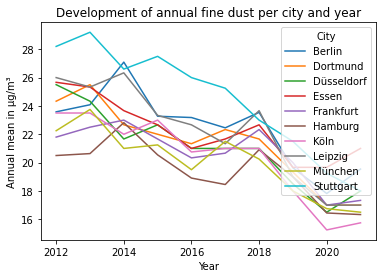

In [16]:
#set year as index
pollution_graph_df = df_air.set_index('Year')

#group by city and choose Annual mean in µg/m³ as variable
pollution_graph_df = pollution_graph_df.groupby('City')['Annual mean in µg/m³']

#create plot
pollution_graph_df.plot(x="Year", y="Annual mean of fine dust in µg/m³",legend=True)
plt.title('Development of annual fine dust per city and year')
plt.xlabel('Year')
plt.ylabel('Annual mean in µg/m³')
plt.legend(title='City')
plt.show()

Number of PKW and KFZ per person (Oliver)

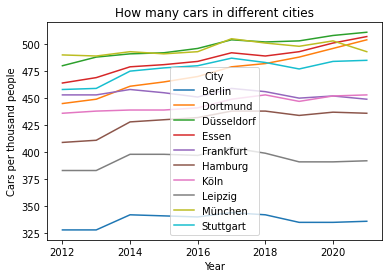

In [17]:
#set year as index
PKW_graph_df = df_pkw.set_index("Year")

#group by city and choose cars per person as variable
PKW_graph_df = PKW_graph_df.groupby('City')["PKW Dichte"]

#create plot
PKW_graph_df.plot(x="Year", y="PKW Dichte",legend=True)
plt.title('How many cars in different cities')
plt.xlabel('Year')
plt.ylabel('Cars per thousand people')
plt.legend(title='City')
plt.show()

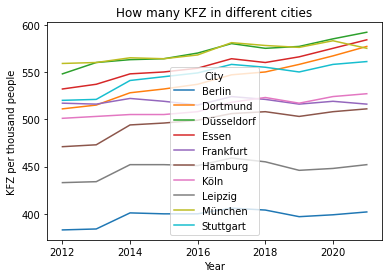

In [18]:
#set year as index
KFZ_graph_df = df_pkw.set_index("Year")

#group by city and choose KFZ per person as variable
KFZ_graph_df = KFZ_graph_df.groupby('City')["KFZ Dichte"]

#create plot
KFZ_graph_df.plot(x="Year", y="KFZ Dichte",legend=True)
plt.title('How many KFZ in different cities')
plt.xlabel('Year')
plt.ylabel('KFZ per thousand people')
plt.legend(title='City')
plt.show()

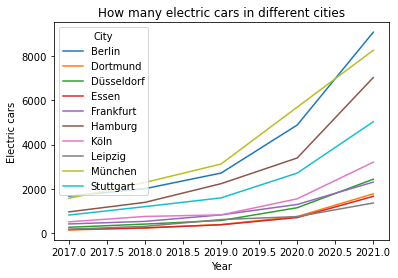

In [95]:
#drop years before 2016 - where we don't have data
Elektro_df = df_pkw.drop(df_pkw[df_pkw.Year < 2017].index)

#set year as index
Elektro_graph = Elektro_df.set_index("Year")

#group by city and choose KFZ per person as variable
Elektro_graph = Elektro_graph.groupby('City')["PKW Elektro"]

#create plot
Elektro_graph.plot(x="Year", y="PKW Elektro",legend=True)
plt.title('How many electric cars in different cities')
plt.xlabel('Year')
plt.ylabel('Electric cars')
plt.legend(title='City')
plt.show()

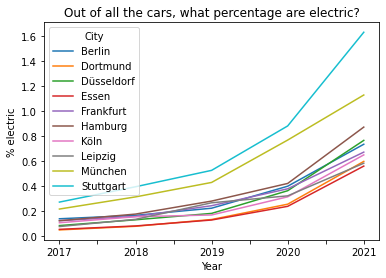

In [96]:
#drop years before 2016 - where we don't have data for electric
Elektro_df = df_pkw.drop(df_pkw[df_pkw.Year < 2017].index)

#make a new column with percentage of electric cars out of total cars
Elektro_df.iloc[:, 1:] = Elektro_df.iloc[:, 1:].astype(int)
Elektro_df["Perc of PKW electric"] = 100*(Elektro_df["PKW Elektro"] / Elektro_df["PKW insgesamt"])
Elektro_df.iloc[:, 1:2] = Elektro_df.iloc[:, 1:2].astype(str)

#set year as index
Elektro_graph = Elektro_df.set_index("Year")

#group by city and choose KFZ per person as variable
Elektro_graph = Elektro_graph.groupby('City')["Perc of PKW electric"]

#create plot
Elektro_graph.plot(x="Year", y="Perc of PKW electric",legend=True)
plt.title('Out of all the cars, what percentage are electric?')
plt.xlabel('Year')
plt.ylabel('% electric')
plt.legend(title='City')
plt.show()

In [23]:

# Coefficient of correlation
# A correlation coefficient (typically denoted r) is a single number that describes the extent of the linear relationship between two variables. 
# A value of +1 indicates perfect linearity (the two variables move together, like “height in inches” and “height in centimeters”). 
# A value of r = 0 indicates no correlation (the variables are independent) and 
# r = -1 indicates the variables are inversely correlated (an increase in one variable is associated with a decrease in the other).
stats.pearsonr(df['PKW Emissionsgruppe Euro 5'], df['Annual mean in µg/m³'])

PearsonRResult(statistic=-0.07516563563672235, pvalue=0.45732517647064724)

Annual mean in µg/m³                                  1.000000
PKW Emissionsgruppe Euro 2                            0.283658
PKW Emissionsgruppe Euro 1                            0.264957
PKW Emissionsgruppe Euro 3                            0.211545
PKW Emissionsgruppe Euro 4                            0.091487
PKW Benzin                                           -0.051925
PKW Emissionsgruppe Euro 5                           -0.075166
PKW insgesamt                                        -0.132059
KFZ insgesamt                                        -0.140440
PKW Dichte                                           -0.150676
LKW insgesamt                                        -0.159528
PKW Emissionsgruppe schadstoffreduzierte insgesamt   -0.165128
KFZ Dichte                                           -0.190721
PKW Diesel                                           -0.214108
PKW Emissionsgruppe sonstige                         -0.311910
PKW Elektro                                          -0

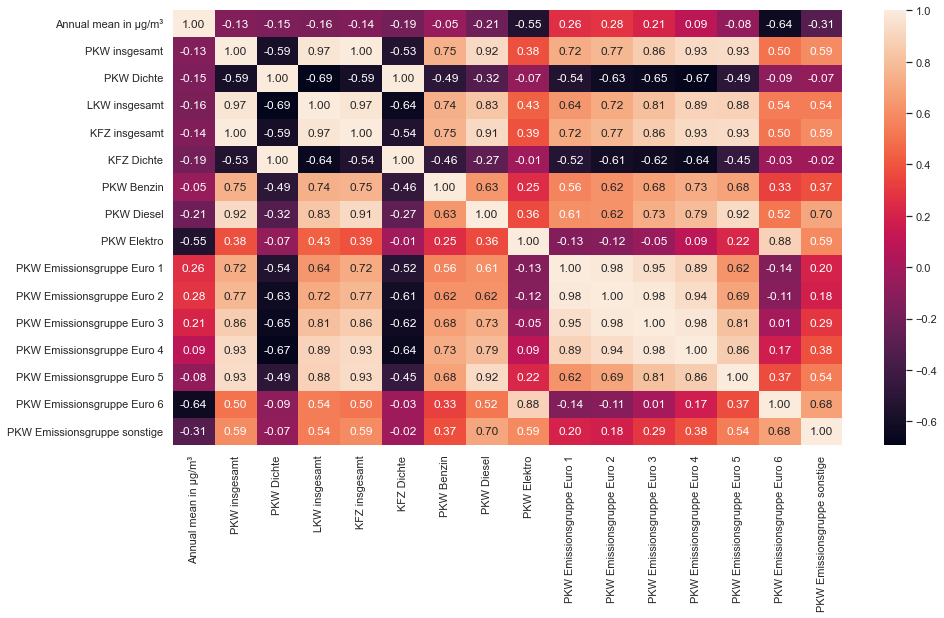

In [52]:
import seaborn as sns

def calcutlate_correlation(df, column_name):
    corr = df.corr()
    return corr[column_name].sort_values(ascending=False)

def print_heatmap(df):
    heatmap = sns.set(rc = {'figure.figsize':(15,8)})
    heatmap = sns.heatmap(df.corr(), annot=True, fmt='.2f')
    plt.show()

print (calcutlate_correlation(df, 'Annual mean in µg/m³'));
print_heatmap(df.iloc[:, 2:18]);
# npcorrcoef = np.corrcoef(df['PKW Emissionsgruppe Euro 5'], df['Annual mean in µg/m³'])
# cormat = df.iloc[:,2:18].corr()
# print(cormat)
# cormat = round(cormat,2)

# heatmap = sns.heatmap(cormat, fmt='.2f')
